The approach in this notebook is a bit different from my Toxic_solution notebook. Here I am modelling dataframes with the available Panda options and resampling using SMOTE.

In [1]:
import eli5
import imblearn
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns

from collections import Counter
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from warnings import simplefilter

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
train_data = pd.read_csv(r'E:\Jupyterfiles\ML_practice\Kaggle\Toxic challenge\train\train.csv')
test_data = pd.read_csv(r'E:\Jupyterfiles\ML_practice\Kaggle\Toxic challenge\test\test.csv')

In [3]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train_data.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


# Check imbalancing

Make copy of train_data

In [5]:
copy_data = train_data.copy()
comments = copy_data['comment_text'].to_numpy()
labels = copy_data[['toxic', 'severe_toxic', 'obscene', 'threat']].to_numpy()
dataframe = []
for index in range(len(labels)):
    num = np.count_nonzero(labels[index])
    if(num == 0):
        dataframe.append([comments[index], 0])
    else:
        dataframe.append([comments[index], 1])

df = pd.DataFrame(dataframe, columns = ['comment', 'label'])
df.head()

,comment,label
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df.tail()

,comment,label
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0
159570,"""\nAnd ... I really don't think you understand...",0


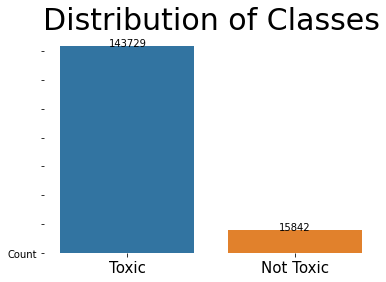

In [7]:
ax = plt.subplot()

g = sns.countplot(df.label)
g.set_xticklabels(['Toxic', 'Not Toxic'])
g.set_yticklabels(['Count'])

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Classes', fontsize=30)
plt.tick_params(axis = 'x', which='major', labelsize=15)
plt.show()

In [8]:
df['label'].value_counts()

0    143729
1     15842
Name: label, dtype: int64

Considerable imbalancing {0:143729, 1:15842}

# Resampling data

In [9]:
# clean comments
clean_df = train_data.loc[(train_data.toxic == 0) &  (train_data.severe_toxic == 0) & (train_data.obscene == 0) &
                   (train_data.threat == 0)  & (train_data.insult == 0) & (train_data.identity_hate == 0)]

# toxic comments
toxic_df = train_data.loc[(train_data.toxic == 1)]

In [10]:
print("Clean data size", clean_df.size)
print("Toxic data size", toxic_df.size)

Clean data size 1146768
Toxic data size 122352


# Splitting data into test and train

## Test data

In [11]:
clean_test= clean_df.iloc[: 28669] # 2.5% of clean comments
toxic_test = toxic_df.iloc[: 3058] # 2.5% of toxic comments

# test_set
test_set = clean_test.append(toxic_test, ignore_index = True).sample(frac = 1)

test_set.drop(['id','severe_toxic','obscene','threat','insult','identity_hate'], axis = 1, inplace = True)
test_set.shape

(31727, 2)

## Train data

In [12]:
clean_train = clean_df.iloc[28669: ] 
toxic_train = toxic_df.iloc[3058: ] 

# train_set
train_set = clean_train.append(toxic_train, ignore_index = True).sample(frac=1)

train_set.drop(['id','severe_toxic','obscene','threat','insult','identity_hate'], axis = 1, inplace = True)
train_set.shape

(126913, 2)

## Cleaning data

In [13]:
def clean_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

train_set['comment_text'] = train_set['comment_text'].apply(lambda x: clean_text(x))
test_set['comment_text'] = test_set['comment_text'].apply(lambda x:clean_text(x))

In [14]:
clean_dict = {0 : 'clean', 1 : 'toxic'} # create a dictionary with the label and description
train_set['target_name'] = train_set['toxic'].map(clean_dict)
test_set['target_name'] = test_set['toxic'].map(clean_dict)

In [15]:
my_stopwords = stopwords.words('english')

# Resampling by overfitting

In [16]:
smt = SMOTE()
vectorizer = TfidfVectorizer(stop_words = my_stopwords, use_idf = True)
bag_of_words = vectorizer.fit_transform(train_set.comment_text)

X_SMOTE, y_SMOTE = smt.fit_sample(bag_of_words, train_set.toxic)
print(Counter(y_SMOTE))

Counter({0: 114677, 1: 114677})


# Random Forest

In [17]:
rf_clf = RandomForestClassifier(25)
rf_clf.fit(X_SMOTE, y_SMOTE)

RandomForestClassifier(n_estimators=25)

## Cross Validation score

In [18]:
score_rf = cross_val_score(rf_clf, X_SMOTE, y_SMOTE, cv = 5)
print('CV scores:', score_rf)

CV scores: [0.97994376 0.98750845 0.98783545 0.98781365 0.98766078]


## Performance Measure

In [19]:
y_test = train_set.toxic
test_features = vectorizer.transform(train_set.comment_text)
y_pred = rf_clf.predict(test_features)
    
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred))
print("Recall Score:", recall_score(y_test, y_pred))
print("F1 Score:",f1_score(y_test, y_pred))

Accuracy Score: 0.9996611852213722
Precision Score: 0.9977140991101314
Recall Score: 0.9987741091860085
F1 Score: 0.9982438227486216


# Features using Explainable AI

Code reference - [eli5 documentation](https://eli5.readthedocs.io/en/latest/overview.html)

In [20]:
simplefilter(action ='ignore', category = FutureWarning)
eli5.show_weights(rf_clf, vec = vectorizer, top = 15, target_names = ['clean','toxic'])

Weight,Feature
0.0223 ± 0.0218,fuck
0.0143 ± 0.0239,fucking
0.0120 ± 0.0197,talk
0.0115 ± 0.0316,article
0.0113 ± 0.0218,shit
0.0090 ± 0.0142,thanks
0.0084 ± 0.0110,suck
0.0083 ± 0.0109,idiot
0.0083 ± 0.0131,stupid
0.0079 ± 0.0115,page


In [21]:
eli5.show_prediction(rf_clf, test_set.comment_text[0], vec = vectorizer, 
                     target_names = list(train_set.target_name.unique()),
                     top = 15)